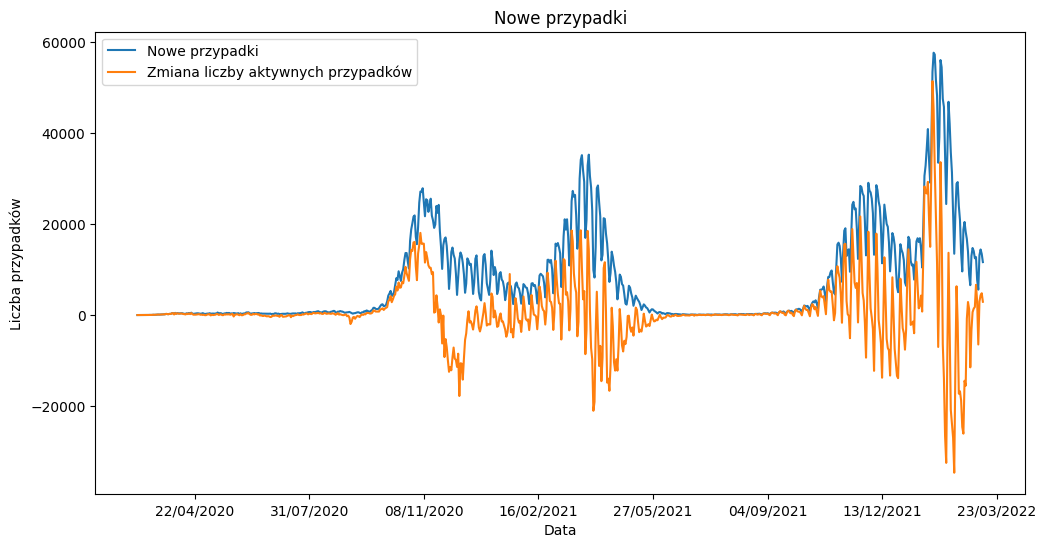

In [30]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch.nn as nn
import torch.optim as optim
import math

df = pd.read_csv('DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=["Data", "Nowe przypadki", "Zmiana liczby aktywnych przypadków"])
df = df.dropna()

def convert_to_datetime_with_year_increment(date_series, start_year):
    previous_month = 0
    current_year = start_year
    datetime_list = []

    for date in date_series:
        current_month = int(date.split('/')[1])
        if current_month == 1 and previous_month == 12:
            current_year += 1
        date_with_year_str = date + f'/{current_year}'
        datetime_obj = datetime.strptime(date_with_year_str, '%d/%m/%Y')
        datetime_list.append(datetime_obj)

        previous_month = current_month

    return datetime_list

df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '').astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '').astype(int)
df['Data'] = df['Data'].apply(lambda x: "{:04.2f}".format(x).replace('.', '/'))
df['Data'] = convert_to_datetime_with_year_increment(df['Data'], 2020)

def visualise(df):
    plt.figure(figsize=(12, 6))
    plt.title('Nowe przypadki')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.xlabel('Data')
    plt.ylabel('Liczba przypadków')
    plt.legend()
    plt.show()

visualise(df)

scaler = MinMaxScaler()
df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków']] = scaler.fit_transform(df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków']])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków']].values
x, y = create_sequences(data, seq_length)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

batch_size = 32
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [41]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(num_features, d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

        self.linear = nn.Linear(d_model, num_features)
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def positional_encoding(self, seq_len, d_model):
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(1)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        src_pe = self.positional_encoding(src.size(0), src.size(2)).to(src.device)
        tgt_pe = self.positional_encoding(tgt.size(0), tgt.size(2)).to(tgt.device)

        src = src + src_pe
        tgt = tgt + tgt_pe

        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        output = self.linear(output)
        return output.permute(1, 0, 2)

num_features = 2
seq_length = 30
d_model = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
dropout = 0.1

model = TimeSeriesTransformer(num_features, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)


In [42]:
epochs = 20
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()

        y_input = torch.zeros_like(x_batch)
        y_input[:, 1:, :] = x_batch[:, :-1, :]
        y_input[:, 0, :] = x_batch[:, 0, :]

        output = model(x_batch, y_input)
        loss = criterion(output[:, -1, :], y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/20, Loss: 0.0620
Epoch 2/20, Loss: 0.0174
Epoch 3/20, Loss: 0.0133
Epoch 4/20, Loss: 0.0120
Epoch 5/20, Loss: 0.0117
Epoch 6/20, Loss: 0.0084
Epoch 7/20, Loss: 0.0070
Epoch 8/20, Loss: 0.0063
Epoch 9/20, Loss: 0.0053
Epoch 10/20, Loss: 0.0052
Epoch 11/20, Loss: 0.0041
Epoch 12/20, Loss: 0.0040
Epoch 13/20, Loss: 0.0041
Epoch 14/20, Loss: 0.0040
Epoch 15/20, Loss: 0.0031
Epoch 16/20, Loss: 0.0034
Epoch 17/20, Loss: 0.0038
Epoch 18/20, Loss: 0.0038
Epoch 19/20, Loss: 0.0032
Epoch 20/20, Loss: 0.0026


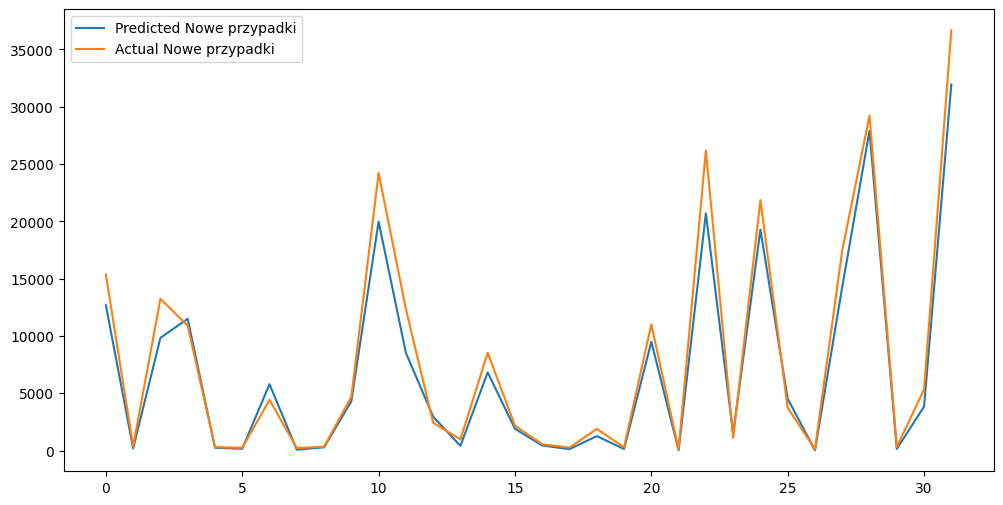

In [43]:
model.eval()
with torch.no_grad():
    for batch in dataloader:
        x_batch, y_batch = batch
        y_input = torch.zeros_like(x_batch)
        y_input[:, 1:, :] = x_batch[:, :-1, :]
        y_input[:, 0, :] = x_batch[:, 0, :]

        output = model(x_batch, y_input)
        predictions = output[:, -1, :]

        predictions_rescaled = scaler.inverse_transform(predictions.numpy())
        y_rescaled = scaler.inverse_transform(y_batch.numpy())

        plt.figure(figsize=(12, 6))
        plt.plot(predictions_rescaled[:, 0], label='Predicted Nowe przypadki')
        plt.plot(y_rescaled[:, 0], label='Actual Nowe przypadki')
        plt.legend()
        plt.show()
        break


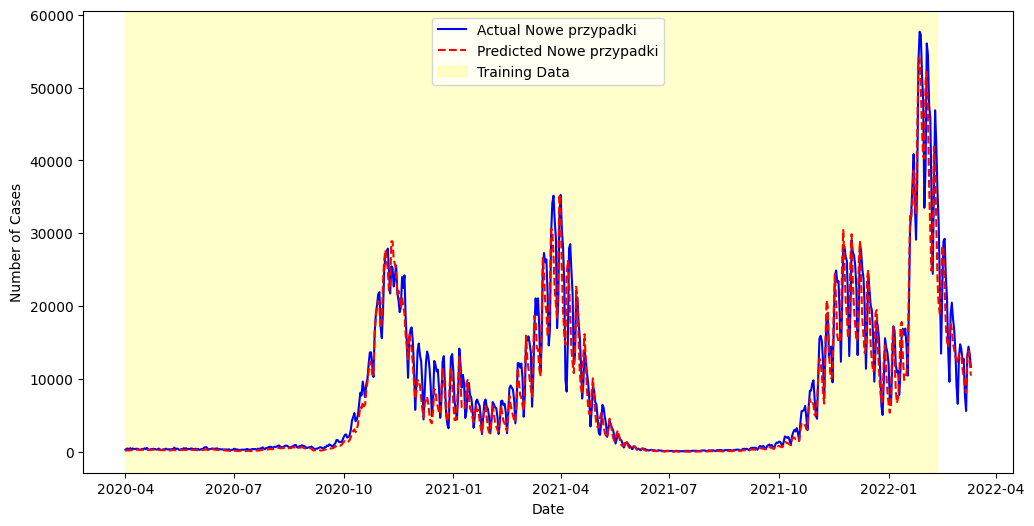

In [44]:
def create_sequences_for_prediction(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length + 1):
        x = data[i:i+seq_length]
        xs.append(x)
    return np.array(xs)

seq_length = 30
data = df[['Nowe przypadki', 'Zmiana liczby aktywnych przypadków']].values
x_all = create_sequences_for_prediction(data, seq_length)

x_all = torch.tensor(x_all, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions_all = []
    for i in range(len(x_all)):
        x_input = x_all[i:i+1]
        y_input = torch.zeros_like(x_input)
        y_input[:, 1:, :] = x_input[:, :-1, :]
        y_input[:, 0, :] = x_input[:, 0, :]

        output = model(x_input, y_input)
        predictions_all.append(output[:, -1, :].numpy())

predictions_all = np.vstack(predictions_all)

predictions_rescaled = scaler.inverse_transform(predictions_all)
y_rescaled = scaler.inverse_transform(data[seq_length-1:])

plt.figure(figsize=(12, 6))
plt.plot(df['Data'][seq_length-1:], y_rescaled[:, 0], label='Actual Nowe przypadki', color='blue')
plt.plot(df['Data'][seq_length-1:], predictions_rescaled[:, 0], label='Predicted Nowe przypadki', color='red', linestyle='dashed')

train_range = range(seq_length-1, len(y_rescaled))
plt.axvspan(df['Data'].iloc[train_range.start], df['Data'].iloc[train_range.stop-1], alpha=0.2, color='yellow', label='Training Data')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()
